In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
%load_ext autoreload
%autoreload 2

Set up training data

In the next cell, we set up the training data for this example. We’ll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [2]:
filename = "/Users/litz/Documents/GitHub/learning_GPyTorch/simple_grid_test.csv"
df = pd.read_csv(filename, index_col=None, header=0)
dfu = df.ix[df["evol_stage"]>=1]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


True

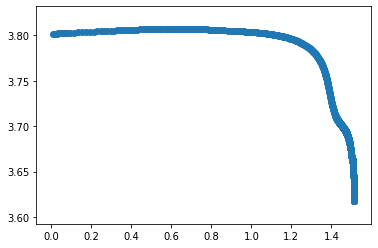

In [3]:
train_x = torch.tensor(list(dfu["frac_age"]))
train_y = torch.tensor(list(np.log10(dfu["effective_T"])))
plt.scatter(train_x, train_y)
torch.is_tensor(train_x)
torch.is_tensor(train_y)

Setting up the model

The next cell demonstrates the most critical features of a user-defined Gaussian process model in GPyTorch. Building a GP model in GPyTorch is different in a number of ways.

First in contrast to many existing GP packages, we do not provide full GP models for the user. Rather, we provide the tools necessary to quickly construct one. This is because we believe, analogous to building a neural network in standard PyTorch, it is important to have the flexibility to include whatever components are necessary. As can be seen in more complicated examples, this allows the user great flexibility in designing custom models.

For most GP regression models, you will need to construct the following GPyTorch objects:

A GP Model (gpytorch.models.ExactGP) - This handles most of the inference.
A Likelihood (gpytorch.likelihoods.GaussianLikelihood) - This is the most common likelihood used for GP regression.
A Mean - This defines the prior mean of the GP.(If you don’t know which mean to use, a gpytorch.means.ConstantMean() is a good place to start.)
A Kernel - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is a good place to start).
A MultivariateNormal Distribution (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.
The GP Model

The components of a user built (Exact, i.e. non-variational) GP model in GPyTorch are, broadly speaking:

An __init__ method that takes the training data and a likelihood, and constructs whatever objects are necessary for the model’s forward method. This will most commonly include things like a mean module and a kernel module.
A forward method that takes in some 𝑛×𝑑 data x and returns a MultivariateNormal with the prior mean and covariance evaluated at x. In other words, we return the vector 𝜇(𝑥) and the 𝑛×𝑛 matrix 𝐾𝑥𝑥 representing the prior mean and covariance matrix of the GP.
This specification leaves a large amount of flexibility when defining a model. For example, to compose two kernels via addition, you can either add the kernel modules directly:

self.covar_module = ScaleKernel(RBFKernel() + WhiteNoiseKernel())

Or you can add the outputs of the kernel in the forward method:

covar_x = self.rbf_kernel_module(x) + self.white_noise_module(x)

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

Model modes

Like most PyTorch modules, the ExactGP has a .train() and .eval() mode. - .train() mode is for optimizing model hyperameters. - .eval() mode is for computing predictions through the model posterior.

Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from torch.optim, and all trainable parameters of the model should be of type torch.nn.Parameter. Because GP models directly extend torch.nn.Module, calls to methods like model.parameters() or model.named_parameters() function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

Zero all parameter gradients
Call the model and compute the loss
Call backward on the loss to fill in gradients
Take a step on the optimizer
However, defining custom training loops allows for greater flexibility. For example, it is easy to save the parameters at each step of training, or use different learning rates for different parameters (which may be useful in deep kernel learning for example).

In [5]:
def model_run(step = None):
    # this is for running the notebook in our testing framework
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else step


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter): 
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()
    return

In [6]:
model_run(step = 50)

Iter 1/50 - Loss: 0.758   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.716   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.682   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 0.640   lengthscale: 0.852   noise: 0.554
Iter 5/50 - Loss: 0.599   lengthscale: 0.907   noise: 0.513
Iter 6/50 - Loss: 0.558   lengthscale: 0.965   noise: 0.474
Iter 7/50 - Loss: 0.521   lengthscale: 1.024   noise: 0.437
Iter 8/50 - Loss: 0.473   lengthscale: 1.081   noise: 0.403
Iter 9/50 - Loss: 0.432   lengthscale: 1.138   noise: 0.370
Iter 10/50 - Loss: 0.390   lengthscale: 1.191   noise: 0.340
Iter 11/50 - Loss: 0.346   lengthscale: 1.240   noise: 0.312
Iter 12/50 - Loss: 0.301   lengthscale: 1.288   noise: 0.286
Iter 13/50 - Loss: 0.256   lengthscale: 1.342   noise: 0.261
Iter 14/50 - Loss: 0.216   lengthscale: 1.397   noise: 0.239
Iter 15/50 - Loss: 0.174   lengthscale: 1.456   noise: 0.218
Iter 16/50 - Loss: 0.124   lengthscale: 1.520   noise: 0.199
Iter 17/50 - Loss: 0.075   length

Make predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

Just as a user defined GP model returns a MultivariateNormal containing the prior mean and covariance from forward, a trained GP model in eval mode returns a MultivariateNormal containing the posterior mean and covariance. Thus, getting the predictive mean and variance, and then sampling functions from the GP at the given test points could be accomplished with calls like:

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

The gpytorch.settings.fast_pred_var context is not needed, but here we are giving a preview of using one of our cool features, getting faster predictive distributions using LOVE.

Plot the model fit

In the next cell, we plot the mean and confidence region of the Gaussian process model. The confidence_region method is a helper method that returns 2 standard deviations above and below the mean.

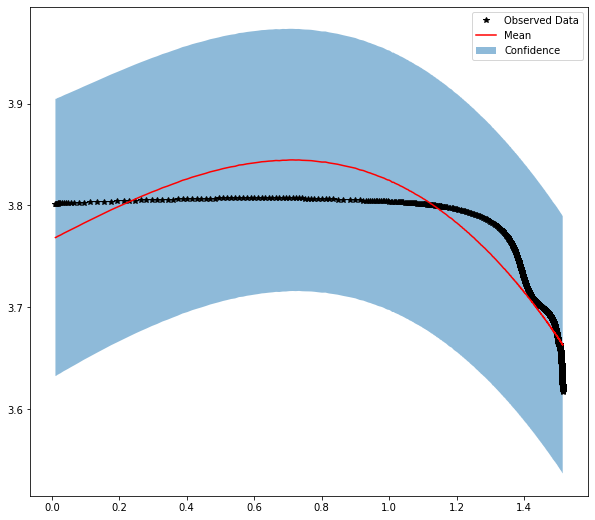

In [10]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


Iter 1/50 - Loss: -3.032   lengthscale: 0.343   noise: 0.000
Iter 2/50 - Loss: -3.056   lengthscale: 0.315   noise: 0.000
Iter 3/50 - Loss: -3.094   lengthscale: 0.289   noise: 0.000
Iter 4/50 - Loss: -3.076   lengthscale: 0.265   noise: 0.000
Iter 5/50 - Loss: -3.036   lengthscale: 0.242   noise: 0.000
Iter 6/50 - Loss: -3.022   lengthscale: 0.222   noise: 0.000
Iter 7/50 - Loss: -2.990   lengthscale: 0.203   noise: 0.000
Iter 8/50 - Loss: -2.964   lengthscale: 0.186   noise: 0.000
Iter 9/50 - Loss: -2.737   lengthscale: 0.171   noise: 0.000
Iter 10/50 - Loss: -2.856   lengthscale: 0.158   noise: 0.000
Iter 11/50 - Loss: -2.756   lengthscale: 0.148   noise: 0.000
Iter 12/50 - Loss: -2.623   lengthscale: 0.139   noise: 0.000
Iter 13/50 - Loss: -2.410   lengthscale: 0.131   noise: 0.000
Iter 14/50 - Loss: -2.480   lengthscale: 0.125   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 181837.90625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 15/50 - Loss: -2.376   lengthscale: 0.119   noise: 0.000
Iter 16/50 - Loss: -2.556   lengthscale: 0.125   noise: 0.000
Iter 17/50 - Loss: -2.463   lengthscale: 0.130   noise: 0.000
Iter 18/50 - Loss: -2.614   lengthscale: 0.135   noise: 0.000
Iter 19/50 - Loss: -2.714   lengthscale: 0.140   noise: 0.000
Iter 20/50 - Loss: -2.589   lengthscale: 0.144   noise: 0.000
Iter 21/50 - Loss: -2.650   lengthscale: 0.148   noise: 0.000
Iter 22/50 - Loss: -2.660   lengthscale: 0.152   noise: 0.000
Iter 23/50 - Loss: -2.687   lengthscale: 0.156   noise: 0.000
Iter 24/50 - Loss: -2.693   lengthscale: 0.159   noise: 0.000
Iter 25/50 - Loss: -2.753   lengthscale: 0.162   noise: 0.000
Iter 26/50 - Loss: -2.750   lengthscale: 0.165   noise: 0.000
Iter 27/50 - Loss: -2.865   lengthscale: 0.167   noise: 0.000
Iter 28/50 - Loss: -2.672   lengthscale: 0.170   noise: 0.000
Iter 29/50 - Loss: -2.823   lengthscale: 0.172   noise: 0.000
Iter 30/50 - Loss: -2.954   lengthscale: 0.174   noise: 0.000
Iter 31/

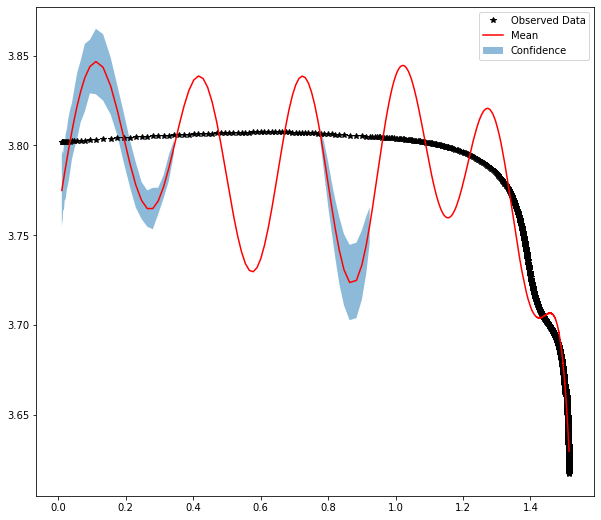

In [12]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])



Iter 1/50 - Loss: -2.635   lengthscale: 0.193   noise: 0.000
Iter 2/50 - Loss: -2.834   lengthscale: 0.176   noise: 0.000
Iter 3/50 - Loss: -2.763   lengthscale: 0.162   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 14.455028533935547 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 4/50 - Loss: -2.588   lengthscale: 0.149   noise: 0.000
Iter 5/50 - Loss: -2.524   lengthscale: 0.138   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3.858785390853882 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 6/50 - Loss: -2.360   lengthscale: 0.132   noise: 0.000
Iter 7/50 - Loss: -2.456   lengthscale: 0.131   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2.474912643432617 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 8/50 - Loss: -2.447   lengthscale: 0.130   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 125311.0546875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 9/50 - Loss: -2.515   lengthscale: 0.132   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3.672329902648926 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 10/50 - Loss: -2.386   lengthscale: 0.126   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2.425546407699585 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 11/50 - Loss: -2.330   lengthscale: 0.121   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3154607.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 12/50 - Loss: -2.352   lengthscale: 0.116   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 752122.8125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 13/50 - Loss: -2.348   lengthscale: 0.111   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 671577.875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 14/50 - Loss: -2.297   lengthscale: 0.107   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1865008.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 15/50 - Loss: -2.268   lengthscale: 0.103   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 483921.21875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 16/50 - Loss: -2.164   lengthscale: 0.099   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 460310.21875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 17/50 - Loss: -2.153   lengthscale: 0.096   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 95374.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 18/50 - Loss: -2.200   lengthscale: 0.094   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 433329.21875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 19/50 - Loss: -2.119   lengthscale: 0.092   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 919.1127319335938 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 20/50 - Loss: -2.232   lengthscale: 0.089   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 105952.4921875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 21/50 - Loss: -2.115   lengthscale: 0.086   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1484750.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 22/50 - Loss: -2.133   lengthscale: 0.083   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5015019.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 23/50 - Loss: -2.124   lengthscale: 0.080   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3756587.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 24/50 - Loss: -2.142   lengthscale: 0.078   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2364080.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 25/50 - Loss: -2.108   lengthscale: 0.074   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 375199.03125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 26/50 - Loss: -2.049   lengthscale: 0.070   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4313916.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 27/50 - Loss: -2.133   lengthscale: 0.067   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1718977.125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 28/50 - Loss: -1.871   lengthscale: 0.064   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 689280.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 29/50 - Loss: -1.951   lengthscale: 0.062   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 874159.1875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 30/50 - Loss: -1.912   lengthscale: 0.060   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 6837152.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 31/50 - Loss: -1.761   lengthscale: 0.058   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 9557643.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 32/50 - Loss: -1.834   lengthscale: 0.055   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2202513.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 33/50 - Loss: -1.742   lengthscale: 0.054   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2515173.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 34/50 - Loss: -1.876   lengthscale: 0.052   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1974079.625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 35/50 - Loss: -1.773   lengthscale: 0.051   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2954523.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 36/50 - Loss: -1.690   lengthscale: 0.050   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1089169.125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 37/50 - Loss: -1.831   lengthscale: 0.048   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7794353.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 38/50 - Loss: -1.794   lengthscale: 0.047   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 15015217.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 39/50 - Loss: -1.749   lengthscale: 0.048   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 8889689.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 40/50 - Loss: -1.755   lengthscale: 0.051   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2873749.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 41/50 - Loss: -1.715   lengthscale: 0.054   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4371212.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 42/50 - Loss: -1.787   lengthscale: 0.057   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 14823300.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 43/50 - Loss: -1.828   lengthscale: 0.058   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3714434.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 44/50 - Loss: -1.985   lengthscale: 0.060   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2688774.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 45/50 - Loss: -1.913   lengthscale: 0.062   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 723175.9375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 46/50 - Loss: -2.007   lengthscale: 0.065   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 8374994.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 47/50 - Loss: -2.031   lengthscale: 0.067   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 836819.9375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 48/50 - Loss: -1.948   lengthscale: 0.068   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4517912.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 49/50 - Loss: -1.917   lengthscale: 0.068   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1459205.125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 50/50 - Loss: -1.984   lengthscale: 0.067   noise: 0.000


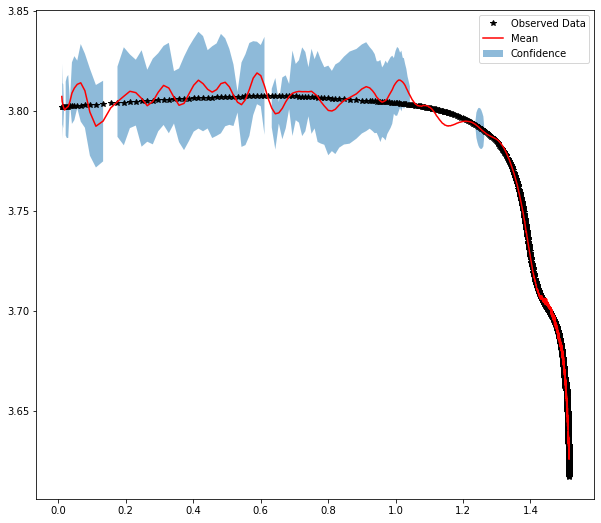

In [13]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])




//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 22874104.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 1/50 - Loss: -0.479   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5191517.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 2/50 - Loss: 0.990   lengthscale: 0.004   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 20160528.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 3/50 - Loss: -0.429   lengthscale: 0.004   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 40374920.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 4/50 - Loss: -0.534   lengthscale: 0.004   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2624713.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 5/50 - Loss: -0.548   lengthscale: 0.004   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 25715200.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 6/50 - Loss: 0.013   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 10595493.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 7/50 - Loss: -0.256   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 11659836.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 8/50 - Loss: 0.447   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 16654559.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 9/50 - Loss: -0.429   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3195450.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 10/50 - Loss: -0.473   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4831022.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 11/50 - Loss: -0.442   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2084315.625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 12/50 - Loss: -0.420   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 11865264.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 13/50 - Loss: -0.394   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 9678820.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 14/50 - Loss: -0.425   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 9900519.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 15/50 - Loss: -0.380   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7001556.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 16/50 - Loss: -0.328   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 119707744.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 17/50 - Loss: -0.357   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3788232.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 18/50 - Loss: -0.314   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 41458752.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 19/50 - Loss: -0.350   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 6148248.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 20/50 - Loss: 0.138   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 18669714.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 21/50 - Loss: 0.674   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 22696576.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 22/50 - Loss: -0.250   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 18505766.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 23/50 - Loss: -0.363   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4881458.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 24/50 - Loss: -0.393   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7730659.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 25/50 - Loss: -0.375   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4426299.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 26/50 - Loss: -0.397   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 678665216.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 27/50 - Loss: -0.420   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3205727.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 28/50 - Loss: -0.384   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1806018.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 29/50 - Loss: -0.444   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1943695.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 30/50 - Loss: -0.429   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 377212064.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 31/50 - Loss: -0.435   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 12613609.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 32/50 - Loss: -0.409   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 10106070.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 33/50 - Loss: -0.419   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5876120.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 34/50 - Loss: -0.429   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2771991.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 35/50 - Loss: -0.403   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 43434088.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 36/50 - Loss: -0.386   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 19262958.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 37/50 - Loss: -0.418   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 17875682.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 38/50 - Loss: -0.375   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3079331.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 39/50 - Loss: -0.412   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5479288.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 40/50 - Loss: -0.404   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2611235.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 41/50 - Loss: -0.339   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4379114.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 42/50 - Loss: -0.389   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 18636098.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 43/50 - Loss: 0.221   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 13723526.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 44/50 - Loss: -0.432   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3694074.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 45/50 - Loss: -0.461   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5297035.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 46/50 - Loss: -0.431   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 9524236.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 47/50 - Loss: -0.179   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5353985.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 48/50 - Loss: -0.439   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 17636968.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 49/50 - Loss: -0.404   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 40750648.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 50/50 - Loss: -0.377   lengthscale: 0.002   noise: 0.000


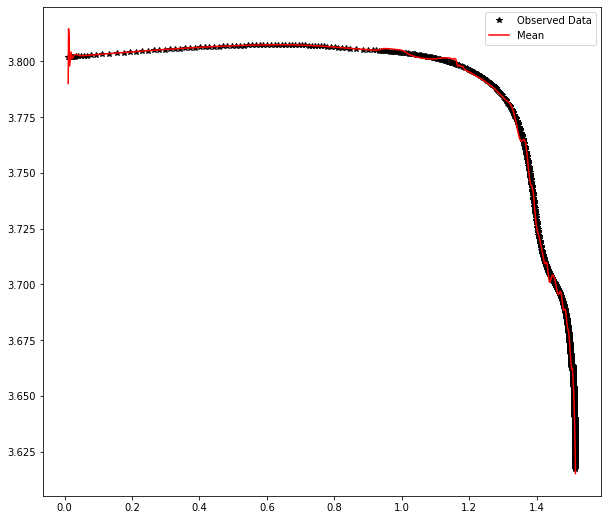

In [16]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])




//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 10500092.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 1/50 - Loss: -0.427   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 18582990.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 2/50 - Loss: -0.466   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 6289265.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 3/50 - Loss: -0.440   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 20490976.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 4/50 - Loss: -0.223   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 22032206.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 5/50 - Loss: -0.485   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3615110.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 6/50 - Loss: -0.478   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 78670488.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 7/50 - Loss: -0.528   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 8656801.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 8/50 - Loss: -0.498   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7592603.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 9/50 - Loss: 0.998   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 55073700.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 10/50 - Loss: -0.520   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 11627209.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 11/50 - Loss: 5.802   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5971442.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 12/50 - Loss: -0.492   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 13676380.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 13/50 - Loss: -0.313   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 16574474.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 14/50 - Loss: -0.483   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7663568.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 15/50 - Loss: -0.441   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 45788936.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 16/50 - Loss: -0.426   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 53995148.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 17/50 - Loss: -0.376   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 15631235.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 18/50 - Loss: -0.300   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4777454.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 19/50 - Loss: -0.461   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1339796.625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 20/50 - Loss: -0.380   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7973288.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 21/50 - Loss: -0.472   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 14391814.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 22/50 - Loss: -0.446   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 26470048.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 23/50 - Loss: -0.456   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5049249.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 24/50 - Loss: -0.397   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2457581.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 25/50 - Loss: -0.414   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 9765420.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 26/50 - Loss: -0.455   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 8528588.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 27/50 - Loss: -0.406   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2800863.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 28/50 - Loss: -0.448   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 28693486.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 29/50 - Loss: -0.431   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1375998.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 30/50 - Loss: -0.444   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2103403.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 31/50 - Loss: -0.427   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2818708.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 32/50 - Loss: -0.169   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2459315.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 33/50 - Loss: -0.455   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3877041.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 34/50 - Loss: -0.466   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3541025.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 35/50 - Loss: -0.448   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 11890422.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 36/50 - Loss: -0.440   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5496422.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 37/50 - Loss: -0.459   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2155165.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 38/50 - Loss: -0.449   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 9472225.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 39/50 - Loss: -0.412   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 10591356.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 40/50 - Loss: -0.442   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3172581.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 41/50 - Loss: -0.434   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 12204465.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 42/50 - Loss: -0.437   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 12395615.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 43/50 - Loss: -0.442   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 10162161.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 44/50 - Loss: -0.439   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1309335.625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 45/50 - Loss: -0.471   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3151996.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 46/50 - Loss: -0.431   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2062457.625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 47/50 - Loss: -0.421   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7899237.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 48/50 - Loss: -0.419   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 54935704.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 49/50 - Loss: -0.445   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2534034.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 50/50 - Loss: -0.418   lengthscale: 0.002   noise: 0.000


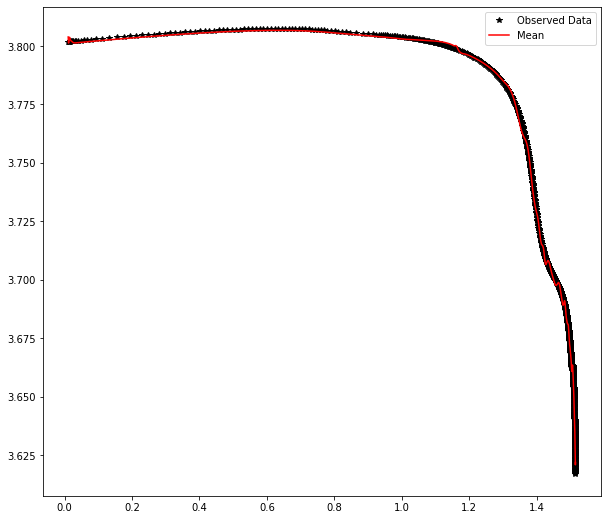

In [17]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3465004.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 1/50 - Loss: -0.447   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7188377.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 2/50 - Loss: -0.465   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 26403454.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 3/50 - Loss: -0.447   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3829928.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 4/50 - Loss: -0.124   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 18296686.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 5/50 - Loss: 0.263   lengthscale: 0.003   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2195469.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 6/50 - Loss: -0.376   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 6261397.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 7/50 - Loss: -0.448   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7977528.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 8/50 - Loss: 0.533   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2778467.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 9/50 - Loss: -0.417   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 8362672.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 10/50 - Loss: -0.428   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3213091.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 11/50 - Loss: -0.434   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 575083.8125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 12/50 - Loss: -0.440   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2008668.125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 13/50 - Loss: -0.276   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 30977556.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 14/50 - Loss: -0.450   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7391928.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 15/50 - Loss: -0.456   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 887863.8125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 16/50 - Loss: -0.462   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3113507.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 17/50 - Loss: -0.485   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2901620.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 18/50 - Loss: -0.425   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3488312.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 19/50 - Loss: -0.440   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1497340.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 20/50 - Loss: -0.487   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 888079.625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 21/50 - Loss: -0.498   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 512444.625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 22/50 - Loss: -0.436   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7359814.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 23/50 - Loss: -0.435   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 807074.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 24/50 - Loss: -0.322   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 327700.6875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 25/50 - Loss: -0.464   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 464841.59375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 26/50 - Loss: -0.453   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 18889958.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 27/50 - Loss: -0.466   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2245002.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 28/50 - Loss: -0.417   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 8062739.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 29/50 - Loss: -0.407   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 15821935.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 30/50 - Loss: -0.377   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 767370.4375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 31/50 - Loss: -0.422   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1041460.4375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 32/50 - Loss: -0.395   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1721696.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 33/50 - Loss: -0.452   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5107144.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 34/50 - Loss: -0.425   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 678043.6875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 35/50 - Loss: -0.425   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1139310.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 36/50 - Loss: -0.455   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 9147468.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 37/50 - Loss: -0.444   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5544532.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 38/50 - Loss: -0.437   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 613228.5625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 39/50 - Loss: -0.449   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 33391712.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 40/50 - Loss: -0.452   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 671627.375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 41/50 - Loss: -0.412   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3388563.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 42/50 - Loss: -0.395   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 522731.96875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 43/50 - Loss: -0.385   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 921728.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 44/50 - Loss: -0.388   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 655791.625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 45/50 - Loss: -0.408   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 938555.8125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 46/50 - Loss: -0.414   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 768389.9375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 47/50 - Loss: -0.415   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1163523.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 48/50 - Loss: -0.400   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 493083.28125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 49/50 - Loss: -0.441   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2605366.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 50/50 - Loss: -0.416   lengthscale: 0.001   noise: 0.000


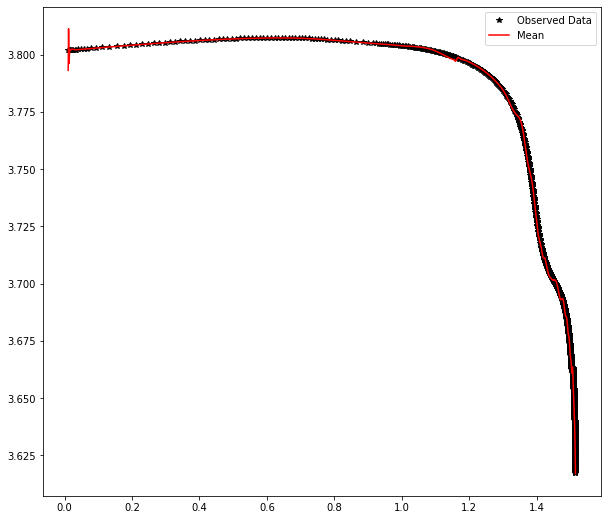

In [18]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 600043.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 1/50 - Loss: -0.396   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 11929295.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 2/50 - Loss: -0.451   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2171138.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 3/50 - Loss: -0.444   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1758745.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 4/50 - Loss: -0.495   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2012123.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 5/50 - Loss: -0.484   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 37755208.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 6/50 - Loss: -0.468   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 10927648.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 7/50 - Loss: -0.358   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 9663479.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 8/50 - Loss: -0.436   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4641917.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 9/50 - Loss: -0.466   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5824643.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 10/50 - Loss: -0.473   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 31396382.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 11/50 - Loss: 1.756   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 12455101.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 12/50 - Loss: -0.481   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2813083.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 13/50 - Loss: -0.358   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2718357.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 14/50 - Loss: -0.412   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5206387.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 15/50 - Loss: -0.445   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4083733.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 16/50 - Loss: -0.448   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7158414.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 17/50 - Loss: -0.440   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2899334.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 18/50 - Loss: -0.433   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 6220298.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 19/50 - Loss: -0.358   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2991361.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 20/50 - Loss: -0.380   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5308426.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 21/50 - Loss: -0.402   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5267305.5 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 22/50 - Loss: 0.564   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1409607.875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 23/50 - Loss: -0.365   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1636422.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 24/50 - Loss: -0.342   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1967886.125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 25/50 - Loss: -0.456   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 120429944.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 26/50 - Loss: -0.361   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1265641.125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 27/50 - Loss: -0.384   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 6899432.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 28/50 - Loss: -0.301   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 796709.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 29/50 - Loss: 0.118   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4195290.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 30/50 - Loss: -0.412   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 897890.8125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 31/50 - Loss: -0.420   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1648064.125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 32/50 - Loss: -0.406   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 85389640.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 33/50 - Loss: -0.411   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 5179694.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 34/50 - Loss: -0.154   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1416876.125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 35/50 - Loss: -0.400   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 20319432.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 36/50 - Loss: -0.377   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1837400.375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 37/50 - Loss: -0.384   lengthscale: 0.002   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 12059993.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 38/50 - Loss: -0.374   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 3804911.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 39/50 - Loss: -0.380   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1705574.375 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 40/50 - Loss: -0.382   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 4679676.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 41/50 - Loss: -0.398   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 14635585.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 42/50 - Loss: -0.373   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1490709.875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 43/50 - Loss: -0.370   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 2254588.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 44/50 - Loss: -0.379   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 16146647.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 45/50 - Loss: -0.401   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 740905.1875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 46/50 - Loss: -0.418   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 970805.1875 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 47/50 - Loss: -0.375   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 1267448.625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 48/50 - Loss: -0.382   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 13861680.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 49/50 - Loss: -0.348   lengthscale: 0.001   noise: 0.000


//anaconda3/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 7168906.0 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 50/50 - Loss: -0.374   lengthscale: 0.001   noise: 0.000


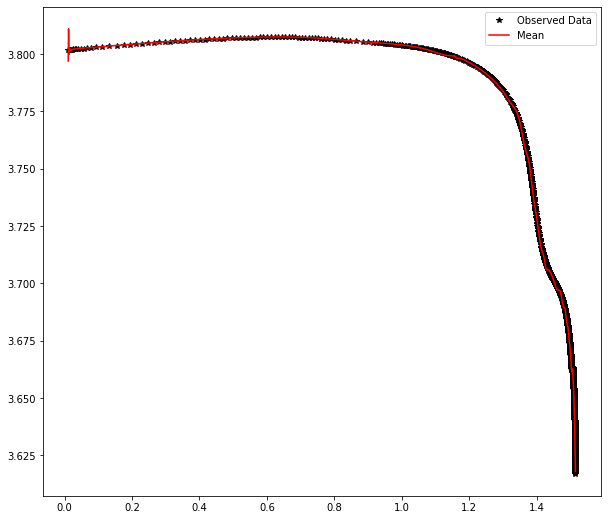

In [19]:
model_run(step = 50)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = train_x
    observed_pred = likelihood(model(test_x))
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 9))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_xlim([3.9,3.6])
    #ax.set_ylim([-.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])